# Liver Model Construction: Notebook-Glycogenolysis

## Setup workflow

### Import packages

In [1]:
import os
import re
import warnings
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

MASSpy version: 0.1.1


## Set paths and constants

In [2]:
seed = int(4)
#increase number of models from before
n_models = 3

mass_config = MassConfiguration()
mass_config.solver = "cplex"

### Directory paths

In [3]:
model_dir = os.path.abspath("../mass_user/models")
maps_dir = os.path.abspath("../mass_user/maps")
data_dir = os.path.abspath("../mass_user/data")

In [4]:
# model_dir = os.path.abspath(".../MASSliver/models")
# maps_dir = os.path.abspath(".../MASSliver/models/maps")
# data_dir = os.path.abspath(".../MASSliver/data/interim")

In [5]:
# Allow Escher to close without pop-up
escher.rc['never_ask_before_quit'] = True


### Load COBRA model

In [6]:
core_model=load_json_cobra_model(filename=os.path.join(model_dir,"CoreModel.json"))
core_model

Name,None
Memory address,0x07ff0ee5af790
Number of metabolites,178
Number of reactions,187
Number of groups,0
Objective expression,1.0*ATPM - 1.0*ATPM_reverse_5b752
Compartments,"m, i, c, r,"


In [7]:
trial = Model('Smaller Glycogenolysis') 
trial

Name,Smaller Glycogenolysis
Memory address,0x07ff1506fd4d0
Number of metabolites,0
Number of reactions,0
Number of groups,0
Objective expression,0
Compartments,


In [8]:
# core_model.reactions.EX_glc__D_c.remove_from_model()

In [9]:
## adding reactions from Recon3D
R3D=load_json_cobra_model(filename=os.path.join(model_dir,"Recon3D.json"))

In [10]:
# ## adding reactions from glycogenloysis 
# gly=load_json_cobra_model(filename=os.path.join(model_dir,"Glycogenolysis.json"))

In [11]:
# r_list=[
   
# #     'EX_pyr_e',
# #     'EX_lac__L_e'  
# ]
# for rid in r_list:
#     reaction = core_model.reactions.get_by_id(rid)
#     trial.add_reactions([reaction])  
r_list_2=[
     'HEX1',
    'PFK',
    'FBP',
    'FBA',
    'TPI',
    'GAPD',
    'PGK',
    'PGM',
    'ENO',
    'G6PPer',
    'G6Pter',
    'GLCter',
    'PGI', 
    'H2Oter',
    'PIter',
    'H2Ot',
    'PIt',
    'EX_glc__D_e',
    'GLCt1',
    'Ht'
]
for rid in r_list_2:
    reaction = R3D.reactions.get_by_id(rid)
    trial.add_reactions([reaction])

In [12]:
# create exchange reaction
pep=R3D.metabolites.get_by_id('pep_c')
atp=R3D.metabolites.get_by_id('atp_c')
adp=R3D.metabolites.get_by_id('adp_c')
h2o=R3D.metabolites.get_by_id('h2o_e')
pie=R3D.metabolites.get_by_id('pi_e')
he=R3D.metabolites.get_by_id('h_e')
nadh=R3D.metabolites.get_by_id('nadh_c')
nad=R3D.metabolites.get_by_id('nad_c')

In [13]:
# create exchange reaction
trial.add_boundary(atp, type="sink")
trial.add_boundary(pep, type="sink")
trial.add_boundary(nadh, type="sink")
trial.add_boundary(nad, type="sink")
trial.add_boundary(adp, type="sink")

trial.add_boundary(h2o, type="exchange")
trial.add_boundary(pie, type="exchange")
trial.add_boundary(he, type="exchange")

Reaction identifier,EX_h_e
Name,H+ exchange
Memory address,0x07ff0ed71b510
Stoichiometry,h_e <=> H+ <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [14]:
trial.reactions

[<Reaction HEX1 at 0x7ff0e6ca9810>,
 <Reaction PFK at 0x7ff0e8ea1b50>,
 <Reaction FBP at 0x7ff0e6cd6f90>,
 <Reaction FBA at 0x7ff0e6eefd50>,
 <Reaction TPI at 0x7ff0e8ec4f90>,
 <Reaction GAPD at 0x7ff0e6c75850>,
 <Reaction PGK at 0x7ff0e6f03d10>,
 <Reaction PGM at 0x7ff0e8f36dd0>,
 <Reaction ENO at 0x7ff0e6f98590>,
 <Reaction G6PPer at 0x7ff0eacabe50>,
 <Reaction G6Pter at 0x7ff0e5fe7e50>,
 <Reaction GLCter at 0x7ff0eabef150>,
 <Reaction PGI at 0x7ff0e6f03a90>,
 <Reaction H2Oter at 0x7ff0eabe9e90>,
 <Reaction PIter at 0x7ff0ea7bbe90>,
 <Reaction H2Ot at 0x7ff0e8f78dd0>,
 <Reaction PIt at 0x7ff0ea219ad0>,
 <Reaction EX_glc__D_e at 0x7ff0e8151f50>,
 <Reaction GLCt1 at 0x7ff0e5df18d0>,
 <Reaction Ht at 0x7ff0e6f87650>,
 <Reaction SK_atp_c at 0x7ff0ed705c10>,
 <Reaction SK_pep_c at 0x7ff0ed705d90>,
 <Reaction SK_nadh_c at 0x7ff0ed705f50>,
 <Reaction SK_nad_c at 0x7ff0ed7a6f10>,
 <Reaction SK_adp_c at 0x7ff0ee641650>,
 <Reaction EX_h2o_e at 0x7ff0ed762d10>,
 <Reaction EX_pi_e at 0x7ff0ed73d

## View Escher map

In [15]:
#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir, ".".join((
            "Glycogenolysis", "map", "json"))
    ),
    highlight_missing=True)

escher_builder


Builder(highlight_missing=True, never_ask_before_quit=True)

### Loading Measured Fluxes

In [16]:
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [17]:
#define data sheet as latest data sheet
data_sheet=os.path.join(data_dir,"3.4-srp-data-collection.xlsx")

flux_df = load_data(
    filepath=data_sheet,
    sheet_name="Fluxes").drop("Fasting Time", axis=1).drop("Additional Notes", axis=1)
flux_df = flux_df.dropna() #drops rows with NaN
flux_df


,Flux (mmol/gDW*hr)
ID,
G6PPer,0.001682
HEX1,0.000000
GLCt1,-0.001682
PGI,-0.002919
EX_glc__D_e,0.085498
FBP,0.002919
PFK,0.000000
FBA,-0.002919
GAPD,-0.002919


In [18]:
v_vars = []
v_data = []

# How much flux to allow through irreversible reaction pairs
# e.g, PFK/FBP & reverse_flux_percent = 0.1, raise both fluxes by 10% of non-zero flux value
reverse_flux_percent = 0.1
irreversible_enzyme_pairs = ["PFK", "FBP"]
irreversible_enzyme_pairs2 = ["HEX1", "G6PPer"]


In [19]:
for rid, flux in flux_df.itertuples():
    reaction = trial.reactions.get_by_id(rid)
    #reaction.bounds = (flux, flux)
    #set bounds for all boundary reactions 
    #uptake --> (-value, 1000)
    #secretion --> (-1000 --> value)
    #reversible --> (-1000,1000)
#     if (rid == "EX_lac__L_e"): #uptake
#         pass
# #         reaction = trial.reactions.get_by_id(rid)
# #         reaction.bounds = (0,1000) 
    if (rid == "EX_glc__L_e"): #secretion
        reaction = trial.reactions.get_by_id(rid)
        reaction.bounds = (0.085498214,0.085498214) ## restricitng glucose  HEPATOKIN Supplemental 15 

#     elif (rid == "EX_pyr_e"): #uptake
#         reaction = trial.reactions.get_by_id(rid)
#         reaction.bounds = (0, 1000) 
#     elif (rid == "SK_f6p_c"): 
#         reaction = trial.reactions.get_by_id(rid)
#         reaction.bounds = (-1000, 0)
#     elif (rid == "SK_g6p_c"): 
#         reaction = trial.reactions.get_by_id(rid)
#         reaction.bounds = (-1000, 0)
#     elif (rid == "EX_glygn2_c"): #uptake
#         reaction = core_model.reactions.get_by_id(rid)
#         reaction.bounds = (-1, 1000) 
    for irreversible_enzyme_pair in irreversible_enzyme_pairs:
        if rid in irreversible_enzyme_pair:
            flux1, flux2 = flux_df.loc[irreversible_enzyme_pairs, "Flux (mmol/gDW*hr)"].values
            if flux1 == 0:
                flux += reverse_flux_percent * flux2 # mmol*gDW^-1*hr^-1
            if flux2 == 0:
                flux += reverse_flux_percent * flux1 # mmol*gDW^-1*hr^-1
    for irreversible_enzyme_pair in irreversible_enzyme_pairs2:
        if rid in irreversible_enzyme_pair:
            flux3, flux4 = flux_df.loc[irreversible_enzyme_pairs2, "Flux (mmol/gDW*hr)"].values
            if flux3 == 0:
                flux += reverse_flux_percent * flux4 # mmol*gDW^-1*hr^-1
            if flux4 == 0:
                flux += reverse_flux_percent * flux3 # mmol*gDW^-1*hr^-1
                
    #address irreversible enzyme pair boundary reactions if necessary

    print(rid, flux)

    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)

G6PPer 0.0018502083831
HEX1 0.00016820076210000002
GLCt1 -0.001682007621
PGI -0.002918552036
EX_glc__D_e 0.0854982138575
FBP 0.0032104072395999998
PFK 0.0002918552036
FBA -0.002918552036
GAPD -0.002918552036
PGK 0.002918552036
PGM 0.002918552036
ENO -0.002918552036


In [20]:
# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)

F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
trial.objective = objective[0]
trial.objective_direction = "min"

flux_solution = trial.optimize()

In [21]:
# ab=pd.DataFrame(flux_solution.fluxes)
# ab.to_excel("output.xlsx")
flux_solution.fluxes

HEX1           0.000233
PFK            0.000975
FBP            0.002527
FBA           -0.001553
TPI           -0.001553
GAPD          -0.003105
PGK            0.003105
PGM            0.003105
ENO           -0.003105
G6PPer         0.001786
G6Pter         0.001786
GLCter        -0.001786
PGI           -0.001553
H2Oter         0.001786
PIter          0.001786
H2Ot           0.007418
PIt            0.007418
EX_glc__D_e    0.001553
GLCt1         -0.001553
Ht             0.001898
SK_atp_c      -0.004313
SK_pep_c      -0.003105
SK_nadh_c     -0.003105
SK_nad_c       0.003105
SK_adp_c       0.004313
EX_h2o_e      -0.007418
EX_pi_e        0.007418
EX_h_e        -0.001898
Name: fluxes, dtype: float64

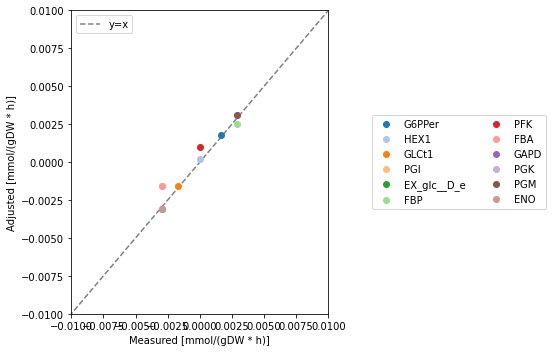

In [22]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_df["Flux (mmol/gDW*hr)"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.01,0.01), ylim=(-0.01, 0.01),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()
#check directionality 


## Create MASS model

In [23]:
glycogenolysis = MassModel("Glycogenolysis", array_type='DataFrame', dtype=np.int64)
glycogenolysis

Name,Glycogenolysis
Memory address,0x07ff0e86bd450
Stoichiometric Matrix,0x0
Matrix Rank,0
Number of metabolites,0
Initial conditions defined,0/0
Number of reactions,0
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Define reactions

In [24]:
#add reactions one at a time
##G6PPer, HEX1, GLCt1, PGI

# EX_glc__D_e    0.001682

# SK_f6p_c      -0.001682
# SK_g6p_c       0.000000
# SK_atp_c      -0.000168
# SK_adp_c       0.000168
# EX_h2o_e      -0.001850
# EX_pi_e        0.001850
# EX_h_e         0.000168


reaction_list=[]
reaction_list = ['HEX1',
                 'PFK',
                 'FBP',
                 'FBA',
                 'TPI',
                 'GLCt1',
                 'G6Pter',
                 'G6PPer',
                 'GLCter',
#                  'EX_glc__D_e',
                'PGI',
                 'H2Oter',
                'PIter',
                'H2Ot',
                'PIt',
                'Ht',
                'GAPD',
                'PGK',
                'PGM',
                'ENO',
#                 #'PEPtm',
#                 #'PEPCKm',
#                 #'LDH_L',
#                 'PYK'
#                 #'PCm',
#                 #'PYRt2m'
                ]


In [25]:
# Convert cobra.Reactions to mass.MassReactions
for rid in reaction_list:
    reaction = trial.reactions.get_by_id(rid)
    glycogenolysis.add_reactions([MassReaction(reaction)])

##  Set Fluxes

In [26]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = glycogenolysis.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux * 1278.605 / 1000 
    # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 0.0002977156684337586
v_PFK: 0.0012463467914784036
v_FBP: 0.003231663479709333
v_FBA: -0.0019853166882309293
v_TPI: -0.0019853166882309293
v_GLCt1: -0.001985316688230929
v_G6Pter: 0.0022830323566646873
v_G6PPer: 0.0022830323566646873
v_GLCter: -0.0022830323566646873
v_PGI: -0.001985316688230929
v_H2Oter: 0.0022830323566646873
v_PIter: 0.0022830323566646873
v_H2Ot: 0.009485329212835878
v_PIt: 0.009485329212835878
v_Ht: 0.0024265709165496967
v_GAPD: -0.0039706333764618585
v_PGK: 0.0039706333764618585
v_PGM: 0.0039706333764618585
v_ENO: -0.0039706333764618585


## Set Keqs

In [27]:
# Load equilibrium constants
Keq_df = pd.read_excel(engine='openpyxl',
    io=data_sheet,
    sheet_name="Keqs",
    index_col=0).drop("Reference", axis=1).drop("Stoichiometry", axis=1).drop('Keq unit', axis=1)

Keq_df = Keq_df.dropna() #drops rows with NaN
Keq_df

,Equlibrium Constant
Reaction,
GLCt1,1.000000
HEX1,28.077000
G6PPer,0.278000
PGI,0.925000
G6Pter,1.000000
GLCter,1.000000
PFK,514.595916
FBP,154.661691
FBA,0.000205


In [54]:
Keq_list =[]
#setting exchange constants as 1

transport= [
    'H2Oter',
    'PIter',
    'H2Ot',
    'PIt',
    'Ht',
    'GLCter',
    'G6Pter'
]
for x in transport:
    a=glycogenolysis.reactions.get_by_id(x)
    a.Keq=1

glycogenolysis.reactions.G6PPer.Keq=1/0.278 ## value seems to be inverted

for rid, Keq in Keq_df.itertuples():
    if rid in reaction_list: 
        reaction = glycogenolysis.reactions.get_by_id(rid)
        reaction.Keq = Keq
        Keq_list.append(reaction.Keq)
        print("{0}: {1}".format(reaction.Keq_str, Keq))
glycogenolysis.reactions.G6PPer.Keq=1/0.278

Keq_GLCt1: 1.0
Keq_HEX1: 28.077
Keq_G6PPer: 0.278
Keq_PGI: 0.925
Keq_G6Pter: 1.0
Keq_GLCter: 1.0
Keq_PFK: 514.5959163
Keq_FBP: 154.6616914
Keq_FBA: 0.0002049897414
Keq_TPI: 8.772406043
Keq_GAPD: 0.6279182855
Keq_PGK: 0.0005001317907
Keq_PGM: 5.726157133
Keq_ENO: 4.364891179


## Obtain Concentrations

In [55]:
compartment_finder_re = re.compile(r"\s*\[([A-Za-z])\]")
rateconst_re = re.compile(r"k_(\S*)_(fwd|rev)\Z")
bound_metabolites_re = re.compile(r"&|@|#")

In [56]:
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [57]:
# prefix_number_id('13dpg_c')

In [58]:
for metabolite in glycogenolysis.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
glycogenolysis.repair()

In [59]:
for metabolite in glycogenolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

adp_c: 0.0007530214275176345
atp_c: 0.012523453843569171
g6p_c: 9.970065514949504e-05
glc__D_c: 0.010482807029999996
h_c: 1
f6p_c: 0.00017852712174570048
fdp_c: 1.9464118378977294e-05
h2o_c: 1
pi_c: 0.0024157660218898304
dhap_c: 4.317077434037322e-05
g3p_c: 9.50047055093457e-05
glc__D_e: 0
g6p_r: 0.0003865535050000001
glc__D_r: 0.010482807029999996
h2o_r: 1
pi_r: 0.0097441228
h2o_e: 1
pi_e: 0.0064
h_e: 1
_13dpg_c: 8.296019357872281e-06
nad_c: 0.0006889876876564443
nadh_c: 1.2280447581091489e-05
_3pg_c: 0.0010233822661485008
_2pg_c: 0.0001833766362339317
pep_c: 0.000821271589227808


In [60]:
#Load Concentration Data
conc_df = load_data(
    filepath=data_sheet,
    sheet_name="Concentrations").drop("Concentration (mM)", axis=1)
conc_df = conc_df.drop("Additional Notes", axis=1)
conc_df = conc_df.dropna() #drops rows with NaN
conc_df

,Name,Concentration(M)
ID,,
glc__D_c,D-Glucose,0.010483
atp_c,ATP C10H12N5O13P3,0.004727
adp_c,ADP C10H12N5O10P2,0.001995
g6p_c,D-Glucose 6-phosphate,0.000140
g6p_r,D-Glucose 6-phosphate,0.000387
pi_r,Phosphate,0.009744
glc__D_r,D-Glucose,0.010483
f6p_c,D-Fructose-6-phosphate,0.000127
glc__D_e,D-Glucose,0.000000


In [62]:
# Fix identifiers in the dataframe
conc_df.index = [prefix_number_id(mid) for mid in conc_df.index]

In [63]:
#Set Concentrations

metabolite_list = [
                    # HEX1    
                    'glc__D_c',
                    'g6p_c',
                    'adp_c',
                    'atp_c',
                    #'pi_c',
                    'h_c',

                    # GLCt1
                    'glc__D_e',

                    # #G6Pter
                    'g6p_r',

                    # #G6PPer , #GLCter
                    'h2o_r',
                    'glc__D_r',
                    'pi_r',
#                     'PGI',
'f6p_c', 
#                     'H2Oter',
'h2o_c',

#                     'PIter',
'pi_r',
'pi_c',

#                     'H2Ot',
'h2o_e',
#                     'PIt',
'pi_e',

#                     'Ht'
'h_e'  ,
    # PFK/ FBP
    'fdp_c',
    # FBA/TPI
    'dhap_c',
    'g3p_c',
    # GAPD
    'nad_c',
    'nadh_c',
    '13dpg_c',
    # PGK
    '3pg_c',
    #PGM
    '2pg_c',
    #ENO
    'pep_c'
    
]

In [64]:
met_list = []
for mid, name, conc in conc_df.itertuples():
    if mid in metabolite_list: 
        metabolite = glycogenolysis.metabolites.get_by_id(mid)
        metabolite.name = name
        
        metabolite.ic = conc #data sheet is in M units
        met_list.append(metabolite.ic)

for metabolite in glycogenolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

adp_c: 0.00199495195
atp_c: 0.004727145980000001
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
h_c: 1
f6p_c: 0.00012713765
fdp_c: 5.1470825e-05
h2o_c: 1
pi_c: 0.0064
dhap_c: 0.00017689737
g3p_c: 8.783869999999999e-06
glc__D_e: 0.0
g6p_r: 0.000386553505
glc__D_r: 0.01048280703
h2o_r: 1
pi_r: 0.0097441228
h2o_e: 1
pi_e: 0.0064
h_e: 1
_13dpg_c: 8.296019357872281e-06
nad_c: 0.00182530972
nadh_c: 4.63542e-06
_3pg_c: 0.0010233822661485008
_2pg_c: 0.0001833766362339317
pep_c: 0.00031


## Set H2O/H Constants

In [65]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
#     "h2o_c",
    "h_c",'h_e',
    'h2o_r','h2o_e',"h2o_c",
    "glc__D_e", "pi_e"
       #'h_i'
       #'h_m' 
    #remove h_i and h_m if not mitochondrial reactions
                  ]:
    metabolite = glycogenolysis.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [66]:
for metabolite in [
    #'h_i',
    #'h_m',
"h_c", 'h_e',
"h2o_c",'h2o_r','h2o_e' 
]:
    metabolite = glycogenolysis.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M
    
glycogenolysis.metabolites.glc__D_e.ic= 0 #setting extracellular glucose as 0 because no lactate rn
   
#plasma phsophate concentration to be equal to intracellular plasma concentration
glycogenolysis.metabolites.pi_e.ic=0.0064



In [67]:
#Formulate QP minimization list for concentrations
## double check this?
conc_solver = ConcSolver(
    glycogenolysis, # bc only want metabolites in glycogenolysis 
    excluded_metabolites=[
        #'h_i', 'h_m', 'co2_m', 'gdp_m', 'gtp_m', 'hco3_m'
        "h_c",'h_e',
    'h2o_r','h2o_e',"h2o_c",
        "pi_e",
        "glc__D_e"
    ], excluded_reactions=["Ht", "H2Ot", "H2Oter",
                            'PIter',
                            'PIt',
                           'G6Pter',
                           'GLCter',
                           'GLCt1'
                          ],
    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(glycogenolysis.fixed))
fixed_Keq_bounds=glycogenolysis.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
adp_c,0.000753,0.0
atp_c,0.012523,0.0
g6p_c,0.000100,0.0
glc__D_c,0.010483,0.0
f6p_c,0.000179,0.0
...,...,...
Keq_PGI,0.658736,0.0
Keq_GAPD,0.237016,0.0
Keq_PGK,0.001325,0.0
Keq_PGM,15.170097,0.0


In [68]:
conc_solution.concentrations

adp_c       0.000753
atp_c       0.012523
g6p_c       0.000100
glc__D_c    0.010483
f6p_c       0.000179
fdp_c       0.000019
pi_c        0.002416
dhap_c      0.000043
g3p_c       0.000095
g6p_r       0.000387
glc__D_r    0.010483
pi_r        0.009744
_13dpg_c    0.000008
nad_c       0.000689
nadh_c      0.000012
_3pg_c      0.001023
_2pg_c      0.000183
pep_c       0.000821
Name: concentrations, dtype: float64

In [69]:
for c in conc_solver.constraints:
    print(c)

HEX1: -1.0*Keq_HEX1 + 1.0*adp_c - 1.0*atp_c + 1.0*g6p_c - 1.0*glc__D_c <= -1
PFK: -1.0*Keq_PFK + 1.0*adp_c - 1.0*atp_c - 1.0*f6p_c + 1.0*fdp_c <= -1
FBP: -1.0*Keq_FBP + 1.0*f6p_c - 1.0*fdp_c + 1.0*pi_c <= -1
FBA: 1 <= -1.0*Keq_FBA + 1.0*dhap_c - 1.0*fdp_c + 1.0*g3p_c
TPI: 1 <= -1.0*Keq_TPI - 1.0*dhap_c + 1.0*g3p_c
G6PPer: -1.0*Keq_G6PPer - 1.0*g6p_r + 1.0*glc__D_r + 1.0*pi_r <= -1
PGI: 1 <= -1.0*Keq_PGI + 1.0*f6p_c - 1.0*g6p_c
GAPD: 1 <= -1.0*Keq_GAPD + 1.0*_13dpg_c - 1.0*g3p_c - 1.0*nad_c + 1.0*nadh_c - 1.0*pi_c
PGK: -1.0*Keq_PGK + 1.0*_13dpg_c - 1.0*_3pg_c + 1.0*adp_c - 1.0*atp_c <= -1
PGM: -1.0*Keq_PGM - 1.0*_2pg_c + 1.0*_3pg_c <= -1
ENO: 1 <= -1.0*Keq_ENO - 1.0*_2pg_c + 1.0*pep_c


mass/visualization/visualization_util.py:1270 UserWarning: Ignoring {'glc__D_e'}, only in one set of given values


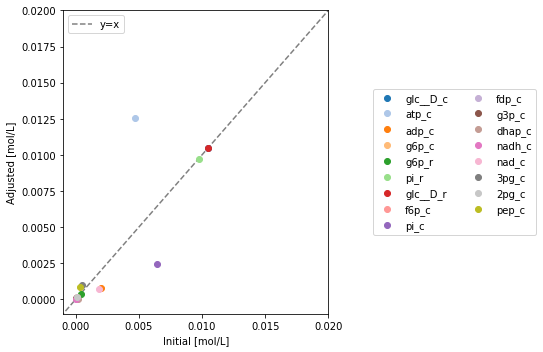

In [70]:
#Compare Results
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration(M)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.001,0.02), ylim=(-0.001,0.02),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    glycogenolysis, conc_solution, concentrations=True, inplace=True);

## Sample Concentrations

In [71]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(glycogenolysis.fixed),
    fixed_Keq_bounds=glycogenolysis.reactions.list_attr("Keq_str"))
for variable in conc_solver.variables:
    try:
        met = glycogenolysis.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=seed)
conc_samples.head()

,adp_c,atp_c,g6p_c,glc__D_c,f6p_c,fdp_c,pi_c,dhap_c,g3p_c,g6p_r,glc__D_r,pi_r,_13dpg_c,nad_c,nadh_c,_3pg_c,_2pg_c,pep_c
0,0.000149,0.025927,0.000166,0.002478,0.000298,0.000026,0.004372,0.000159,0.000384,0.000430,0.002464,0.014864,0.000036,0.000850,0.000041,0.000420,0.000075,0.000337
1,0.001191,0.018382,0.000251,0.006869,0.000449,0.000006,0.002183,0.000017,0.000133,0.001196,0.073308,0.020992,0.000020,0.002115,0.000025,0.002716,0.000487,0.002180
2,0.000626,0.012161,0.000139,0.002729,0.000248,0.000003,0.000462,0.000015,0.000113,0.002165,0.096395,0.001519,0.000007,0.005300,0.000039,0.000775,0.000139,0.000622


## Set concentrations and balance models with pseudoreactions

In [72]:
glycogenolysis.boundary_conditions['glc__D_b']=0.010482807 ##  initial condition of the metabolite in the model


In [73]:
# glycogenolysis.steady_state_fluxes.values
glycogenolysis.update_S(array_type="DataFrame")

,HEX1,PFK,FBP,FBA,TPI,GLCt1,G6Pter,G6PPer,GLCter,PGI,H2Oter,PIter,H2Ot,PIt,Ht,GAPD,PGK,PGM,ENO
adp_c,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
atp_c,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
g6p_c,1,0,0,0,0,0,-1,0,0,-1,0,0,0,0,0,0,0,0,0
glc__D_c,-1,0,0,0,0,1,0,0,-1,0,0,0,0,0,0,0,0,0,0
h_c,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
f6p_c,0,-1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
fdp_c,0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
h2o_c,0,0,-1,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,0,1
pi_c,0,0,1,0,0,0,0,0,0,0,0,1,0,-1,0,-1,0,0,0
dhap_c,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [74]:
# for r, v in glycogenolysis.steady_state_fluxes.items():
#      if not r.boundary:
#         print(r,v)
# for r, v in glycogenolysis.steady_state_fluxes.items():
#      if not (r.boundary or r== glycogenolysis.reactions.GLCter or r==glycogenolysis.reactions.PIter):
#             print(r,v)

In [75]:
transport= [
#  'H2Oter',
    'PIter',
#      'H2Ot',
    'PIt',
#      'Ht',
    'GLCter',
     'G6Pter'
]
for x in transport:
    a=glycogenolysis.reactions.get_by_id(x)
    a.kf=1e6

In [76]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = glycogenolysis.copy()
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0 or new_model.metabolites.get_by_id(mid).compartment== "e": # to remove SK_glc__D_e
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)
        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)

        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items() 
                    if not (r.boundary or r== new_model.reactions.GLCter or r== new_model.reactions.PIter 
                           or r== new_model.reactions.G6Pter or r== new_model.reactions.PIt)},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            percs = new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not (r.boundary  or r== new_model.reactions.GLCter or r== new_model.reactions.PIter
                           or r== new_model.reactions.G6Pter or r== new_model.reactions.PIt)},
                update_reactions=False)
            print(percs)
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(len(models_for_ensemble)))
# print(models_for_ensemble)

Number of models in ensemble: 3


In [77]:
len(models_for_ensemble)

3

#### Ensure model is in steady state and export

In [78]:
## determine imbalances in the reduced network
fluxes = np.array(list(glycogenolysis.steady_state_fluxes.values()))
imbalanced_metabolites = glycogenolysis.S.dot(fluxes)

# Iterate through metabolites
for mid, imbalance in imbalanced_metabolites.iteritems():
    # Ignore balanced metabolites
    if imbalance == 0 or glycogenolysis.metabolites.get_by_id(mid).compartment== "e": # to remove SK_glc__D_e:
        continue
    # Get metabolite object
    met = glycogenolysis.metabolites.get_by_id(mid)

    # Add boundary reactions for imbalanced metabolites
    boundary_type = "sink"    
    # Add boundary reaction with imbalance as flux value
    boundary_reaction = glycogenolysis.add_boundary(
        mid, boundary_type, boundary_condition=met.ic)

    boundary_reaction.Keq = 1
    if imbalance < 0:
        boundary_reaction.reverse_stoichiometry(inplace=True)
        imbalance = -imbalance

    boundary_reaction.kf = imbalance / met.ic
    boundary_reaction.steady_state_flux = imbalance
    try:
        # Update PERCs
            percs= glycogenolysis.calculate_PERCs(
            fluxes={
                r: v for r, v in glycogenolysis.steady_state_fluxes.items()
                if not (r.boundary  or r== glycogenolysis.reactions.GLCter or r== glycogenolysis.reactions.PIter
                           or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt)},
            update_reactions=True)
            print(percs)
    except:
        print("Negative PERCs for {0}".format(new_model.id))
        continue

{'kf_HEX1': 2.2678212833876645, 'kf_PFK': 557.4630799858645, 'kf_FBP': 166.0556347304471, 'kf_FBA': 59.36092484709171, 'kf_TPI': 26.76366328756877, 'kf_GLCt1': 0.18938788843000667, 'kf_G6PPer': 6.3743901658999444, 'kf_PGI': 11.588771072535977, 'kf_H2Oter': 100000.0, 'kf_H2Ot': 100000.0, 'kf_Ht': 100000.0, 'kf_GAPD': 14613489.9723722, 'kf_PGK': 490.11485638110184, 'kf_PGM': 34.254361090293884, 'kf_ENO': 12.601475215582113}
{'kf_HEX1': 2.2678212833876645, 'kf_PFK': 557.4630799858645, 'kf_FBP': 166.0556347304471, 'kf_FBA': 59.36092484709171, 'kf_TPI': 26.76366328756877, 'kf_GLCt1': 0.18938788843000667, 'kf_G6PPer': 6.3743901658999444, 'kf_PGI': 11.588771072535977, 'kf_H2Oter': 100000.0, 'kf_H2Ot': 100000.0, 'kf_Ht': 100000.0, 'kf_GAPD': 14613489.9723722, 'kf_PGK': 490.11485638110184, 'kf_PGM': 34.254361090293884, 'kf_ENO': 12.601475215582113}
{'kf_HEX1': 2.2678212833876645, 'kf_PFK': 557.4630799858645, 'kf_FBP': 166.0556347304471, 'kf_FBA': 59.36092484709171, 'kf_TPI': 26.76366328756877, 

In [79]:
# glycogenolysis.reactions.EX_glc__D_e.kf= 1000
for reaction in glycogenolysis.reactions:
    print(reaction.id, reaction.kf)

HEX1 2.2678212833876645
PFK 557.4630799858645
FBP 166.0556347304471
FBA 59.36092484709171
TPI 26.76366328756877
GLCt1 0.18938788843000667
G6Pter 1000000.0
G6PPer 6.3743901658999444
GLCter 1000000.0
PGI 11.588771072535977
H2Oter 100000.0
PIter 1000000.0
H2Ot 100000.0
PIt 1000000.0
Ht 100000.0
GAPD 14613489.9723722
PGK 490.11485638110184
PGM 34.254361090293884
ENO 12.601475215582113
SK_adp_c 7.32342485200379
SK_atp_c 0.44034943596696663
SK_h_c 8.673617379884035e-19
SK_f6p_c 4.858431198055714e-15
SK_fdp_c 2.2281043536120744e-14
SK_h2o_c 8.673617379884035e-19
SK_pi_c 3.590421134037948e-16
SK_nad_c 5.762996128374598
SK_nadh_c 323.32969545634
SK_pep_c 4.834738506168471


In [80]:
## balancing charges on reactions manually

glycogenolysis.metabolites.h_c.charge=1

glycogenolysis.metabolites.h_e.charge=1
# glycolysis.metabolites.h_c.charge=1
# glycolysis.metabolites.h_m.charge=1
# glycolysis.metabolites.h_i.charge=1
glycogenolysis.metabolites.pi_c.charge=-2
glycogenolysis.metabolites.pi_e.charge=-2
# glycolysis.metabolites.pi_m.charge=-2
glycogenolysis.metabolites.pi_r.charge=-2


In [81]:
glycogenolysis.calculate_PERCs(fluxes={
                r: v for r, v in glycogenolysis.steady_state_fluxes.items()
                if not (r.boundary  or r== glycogenolysis.reactions.GLCter or r== glycogenolysis.reactions.PIter
                           or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt)}, update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in glycogenolysis.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

Forward Rate Constants
----------------------
kf_HEX1: 2.267821
kf_PFK: 557.463080
kf_FBP: 166.055635
kf_FBA: 59.360925
kf_TPI: 26.763663
kf_GLCt1: 0.189388
kf_G6Pter: 1000000.000000
kf_G6PPer: 6.374390
kf_GLCter: 1000000.000000
kf_PGI: 11.588771
kf_H2Oter: 100000.000000
kf_PIter: 1000000.000000
kf_H2Ot: 100000.000000
kf_PIt: 1000000.000000
kf_Ht: 100000.000000
kf_GAPD: 14613489.972372
kf_PGK: 490.114856
kf_PGM: 34.254361
kf_ENO: 12.601475
kf_SK_adp_c: 7.323425
kf_SK_atp_c: 0.440349
kf_SK_h_c: 0.000000
kf_SK_f6p_c: 0.000000
kf_SK_fdp_c: 0.000000
kf_SK_h2o_c: 0.000000
kf_SK_pi_c: 0.000000
kf_SK_nad_c: 5.762996
kf_SK_nadh_c: 323.329695
kf_SK_pep_c: 4.834739


In [84]:
model= models_for_ensemble[0]


In [85]:
list(range(len(list(model.genes))))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [90]:
for x in list(range(len(list(model.genes)))):
#     print(a)
    a= model.genes[x]
    model.genes.remove(a)

In [91]:
for x in list(range(len(list(model.genes)))):
#     print(a)
    a= model.genes[x]
    model.genes.remove(a)

In [92]:
# Whether to print messages as loop occurs. 
verbose = False
# Ensure all models are simulated to a long time and that
# there are enough time points to determine if model reached steady state.
tfinal = 1e4

sim = Simulation(reference_model=models_for_ensemble[0], verbose=verbose)
sim.add_models(models_for_ensemble[1:], verbose=verbose, disable_safe_load=True)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

models_to_export = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in models_for_ensemble:
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " first attempt failed.")
        # First attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 10, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " second attempt failed.")
        # Second attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 100, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " third attempt failed. Eliminating model.")
        # Third attempt was not successful, eliminate the model
        sim.remove_models(models=model, verbose=verbose)

MassSimulationError: Cannot load SBML Model 'Glycogenolysis_C0' 

In [95]:
models_for_ensemble = []
qcqa_model(glycogenolysis, parameters=True, concentrations=True,
          fluxes=True, superfluous=True, elemental=True)


╒══════════════════════════════════════════╕
│ MODEL ID: Glycogenolysis                 │
│ SIMULATABLE: True                        │
│ PARAMETERS NUMERICALY CONSISTENT: True   │
╞══════════════════════════════════════════╡
╘══════════════════════════════════════════╛


In [100]:
# range(len(glycogenolysis.genes))
for x in (range(len(list(glycogenolysis.genes)))):
    a= glycogenolysis.genes[x]
    glycogenolysis.genes.remove(a)



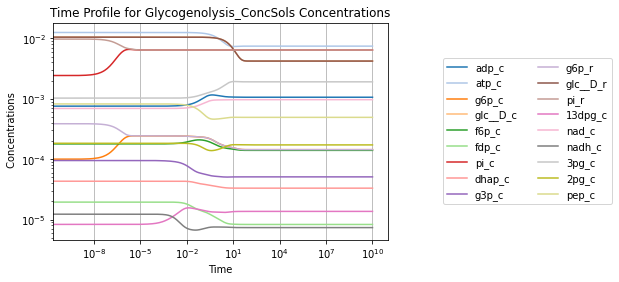

In [101]:
###RUN THIS FOR TIME PROFILE
# Setup simulation object
sim = Simulation(glycogenolysis, verbose=False)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycogenolysis, time=(0, 1e10, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

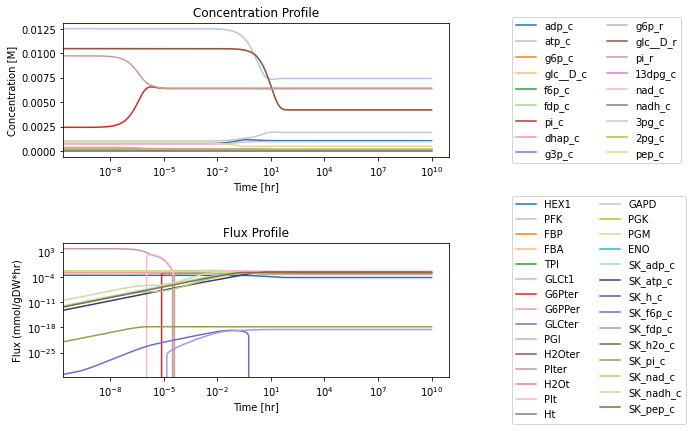

In [102]:
fig_1, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6));
(ax1, ax2) = axes.flatten()
L_FONT = {"size": "large"}
plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    plot_function="semilogx",
    xlabel="Time [hr]", ylabel="Concentration [M]",
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    plot_function="loglog",
    xlabel="Time [hr]", ylabel="Flux (mmol/gDW*hr)",
    title=("Flux Profile", L_FONT));
fig_1.tight_layout()

